# Идентификация частотного скана сигнала релаксации, состоящего из пяти экспоненциальных составляющих, моноэкспоненциальной моделью

## Импорт необходимых модулей

In [1]:
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

%matplotlib inline

from fsmodels import FrequencyScan, MultiExpFrequencyScan

## Ввод параметров моделирования

In [2]:
N_EXPS = 5

N_SCANS = 31

CENTRAL_TIME_CONSTANT_POWER = -2

DEV = 1.0

F_PULSE = 20 * 10 ** -6


FREQUENCY_POWERS = np.linspace(0, 3.5, 100)

## Расчёт массива параметров моделей частотных сканов

In [3]:
def get_exps_params(n_exps,
                    n_scans,
                    central_time_constant_power,
                    dev,
                    amps = None
                   ):
    
    dev = np.linspace(-dev, dev, n_exps) * np.linspace(0, 1, n_scans).reshape(-1,1)
    time_constant_powers = central_time_constant_power + dev
    
    if amps is None:
        amplitudes = np.ones_like(time_constant_powers)
    else:
        amplitudes = np.array(amps)
        
    exps_params = np.stack([time_constant_powers, amplitudes], axis=-1)
    
    return exps_params

In [4]:
exps_params = get_exps_params(n_exps = N_EXPS,
                n_scans = N_SCANS,
                central_time_constant_power = CENTRAL_TIME_CONSTANT_POWER,
                dev = DEV,
                amps = None
               )

## Расчёт массива тестовых данных (сканов, на которых будет выполняться идентификация модели)

In [5]:
def test_data_prep(exps_params,
                   f_pulse,
                   frequency_powers,
                   n_jobs = 1
                  ):
    
    def get_dlts(params):
        model = MultiExpFrequencyScan(n_exps = params.shape[0], 
                                      filling_pulse = f_pulse,
                                      exps_params = params)
        return model(frequency_powers).numpy()
    
    return Parallel(n_jobs=n_jobs)(delayed(get_dlts)(params) for params in exps_params)

In [6]:
test_data = test_data_prep(frequency_powers =FREQUENCY_POWERS,
                           exps_params = exps_params,
                           f_pulse = F_PULSE,
                           n_jobs = -1,
                          )

## Идентификация параметров моделей на массиве тестовых данных

In [7]:
def identification(frequency_powers,
                   dlts,
                   f_pulse,
                  ):
    
    max_abs_index = np.absolute(dlts).argmax()
    initial_time_constant = -frequency_powers[max_abs_index]
    initial_amplitude = dlts[max_abs_index]
    
    
    model = FrequencyScan(amplitude = initial_amplitude,
                          time_constant_power = initial_time_constant,
                          filling_pulse = f_pulse,
                          fit_p_coef = True,
                          learning_rate = 0.05,
                          n_iters = 1000,
                          stop_val = 10**-10,
                          verbose = True,
                          tf_in_out = False
                         )
    
    fit_results = model.fit(frequency_powers, dlts)
    
    return fit_results.iloc[[0], :], fit_results.iloc[[-1], :]


def batch_identification(test_data,
                         frequency_powers,
                         f_pulse,
                         n_jobs = 1
                        ):
    res = Parallel(n_jobs=n_jobs)(delayed(identification)(frequency_powers, dlts, f_pulse) for dlts in test_data)
    
    res = [pd.concat(frame, ignore_index=True) for frame in zip(*res)]
    
    return {'initial_params': res[0], 'final_params': res[1]}

In [8]:
identification_results = batch_identification(test_data = test_data,
                                              frequency_powers = FREQUENCY_POWERS, 
                                              f_pulse = F_PULSE,
                                              n_jobs = -1)

In [9]:
identification_results['initial_params']

,amplitude,time_constant_power,p_coef,loss
0,4.996696,-1.626263,1.0,1.523297
1,4.990662,-1.661616,1.0,1.26185
2,4.973182,-1.661616,1.0,1.250852
3,4.944284,-1.661616,1.0,1.233045
4,4.904321,-1.661616,1.0,1.209183
5,4.853779,-1.661616,1.0,1.180261
6,4.793272,-1.661616,1.0,1.147456
7,4.723534,-1.661616,1.0,1.112067
8,4.645403,-1.661616,1.0,1.075444
9,4.559806,-1.661616,1.0,1.038918


In [10]:
# identification_results['final_params'].to_csv('../models/5-exp-clear/models_parameters.csv', index=False)
identification_results['final_params']

,amplitude,time_constant_power,p_coef,loss
0,4.999864,-2.0,0.999962,0.0
1,4.994529,-2.000003,0.997959,0.000001
2,4.978612,-2.000007,0.991996,0.000012
3,4.952357,-2.000006,0.982196,0.000058
4,4.916169,-1.999985,0.968765,0.000179
5,4.870587,-1.999925,0.951971,0.000424
6,4.816262,-1.999805,0.932132,0.000848
7,4.753943,-1.999598,0.909609,0.001503
8,4.684436,-1.999274,0.884778,0.002439
9,4.608587,-1.998803,0.858024,0.003694


## Вывод графиков на экран

In [11]:
def plot_model(frequency_powers, experimental_values, initial_params, final_params, f_pulse):
    model = FrequencyScan(amplitude = initial_params['amplitude'],
                          time_constant_power = initial_params['time_constant_power'],
                          filling_pulse = f_pulse,
                          p_coef = initial_params['p_coef'],
                         )
    initial_dlts = model(frequency_powers)
    
    model = FrequencyScan(amplitude = final_params['amplitude'],
                          time_constant_power = final_params['time_constant_power'],
                          filling_pulse = f_pulse,
                          p_coef = final_params['p_coef'],
                         )
    final_dlts = model(frequency_powers)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    ax.plot(frequency_powers, experimental_values, 'xg', label='Экспериментальные\nданные', )
    ax.plot(frequency_powers, initial_dlts, '--b', label='Начальная\nмодель')
    ax.plot(frequency_powers, final_dlts, '-r', label='Идентифицированная\nмодель')
    ax.grid()
    ax.set_xlim([0, 3.5])
    ax.legend()
    ax.set_ylabel('DLTS, условные еденицы')
    ax.set_xlabel('log10(Частота), log10(Гц)')
    plt.title('Результат идентификации модели')
    
    return fig, ax

In [12]:
def plot_spectr(exps_params):
    fig, ax = plt.subplots(1,1)
    
    for TC, AMP in exps_params:
        ax.semilogx([10 ** TC, 10 ** TC], [0, AMP], '-b')
        
    ax.set_title('Спектр')
    ax.set_xlabel('Постоянная времени, с')
    ax.set_ylabel('Амплитуда')
    ax.grid()
    ax.set_xlim([1, 1/2500])
    ax.set_ylim([0, 1.4])
    
    return fig, ax

In [13]:
def batch_plot(frequency_powers, 
               experimental_values, 
               exps_params,
               identification_results,
               f_pulse
              ):
    
    for i in range(exps_params.shape[0]):
        print(f'Спектр № {i}')
        print(f'exps_params:\n{exps_params[i]}')
        print(f"Результаты идентификации:\n{identification_results['final_params'].iloc[[i], :]}")
        
        plot_spectr(exps_params[i])
        plt.show()
        
        plot_model(frequency_powers = frequency_powers, 
                   experimental_values = experimental_values[i], 
                   initial_params = identification_results['initial_params'].iloc[[i], :], 
                   final_params = identification_results['final_params'].iloc[[i], :], 
                   f_pulse = f_pulse)
        plt.show()

Спектр № 0
exps_params:
[[-2.  1.]
 [-2.  1.]
 [-2.  1.]
 [-2.  1.]
 [-2.  1.]]
Результаты идентификации:
  amplitude time_constant_power    p_coef loss
0  4.999864                -2.0  0.999962  0.0


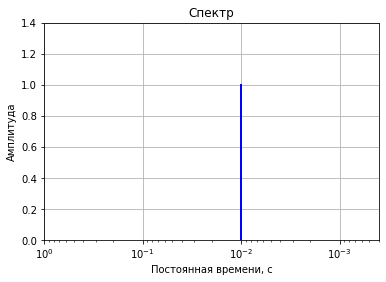

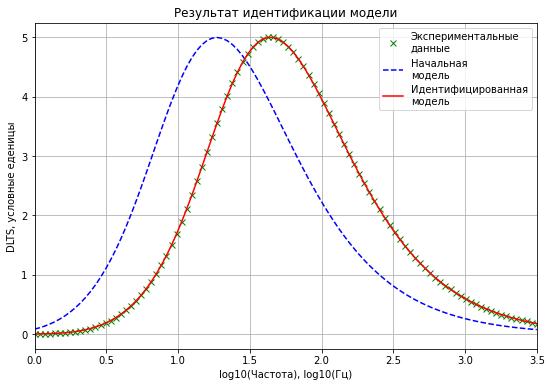

Спектр № 1
exps_params:
[[-2.03333333  1.        ]
 [-2.01666667  1.        ]
 [-2.          1.        ]
 [-1.98333333  1.        ]
 [-1.96666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
1  4.994529           -2.000003  0.997959  0.000001


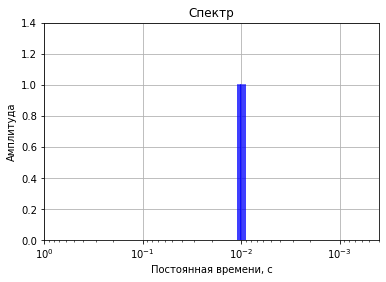

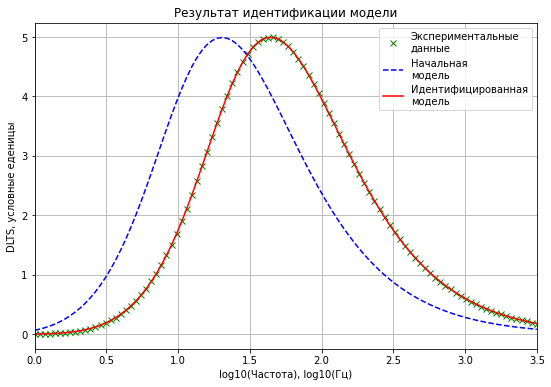

Спектр № 2
exps_params:
[[-2.06666667  1.        ]
 [-2.03333333  1.        ]
 [-2.          1.        ]
 [-1.96666667  1.        ]
 [-1.93333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
2  4.978612           -2.000007  0.991996  0.000012


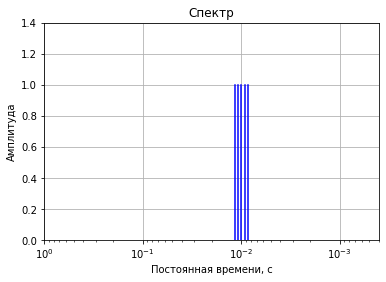

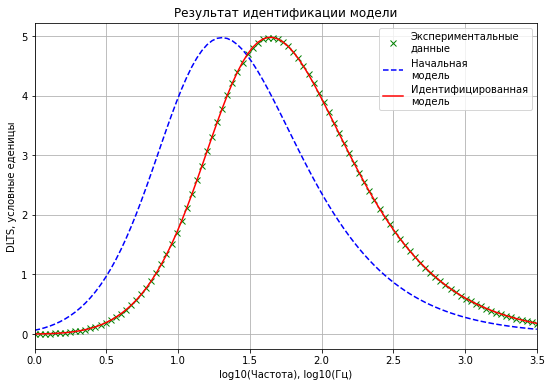

Спектр № 3
exps_params:
[[-2.1   1.  ]
 [-2.05  1.  ]
 [-2.    1.  ]
 [-1.95  1.  ]
 [-1.9   1.  ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
3  4.952357           -2.000006  0.982196  0.000058


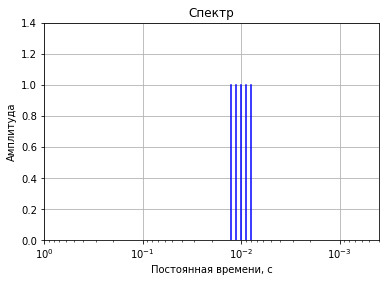

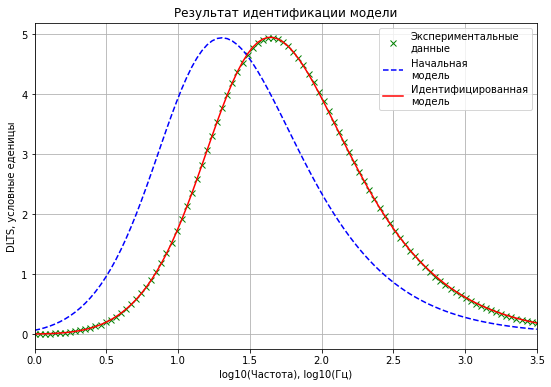

Спектр № 4
exps_params:
[[-2.13333333  1.        ]
 [-2.06666667  1.        ]
 [-2.          1.        ]
 [-1.93333333  1.        ]
 [-1.86666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
4  4.916169           -1.999985  0.968765  0.000179


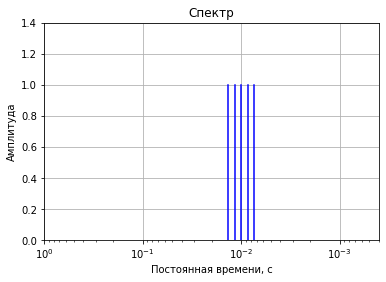

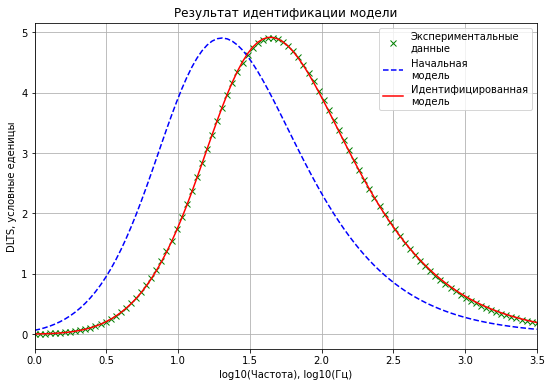

Спектр № 5
exps_params:
[[-2.16666667  1.        ]
 [-2.08333333  1.        ]
 [-2.          1.        ]
 [-1.91666667  1.        ]
 [-1.83333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
5  4.870587           -1.999925  0.951971  0.000424


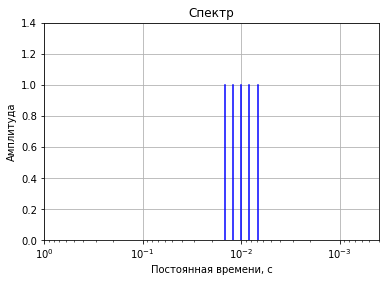

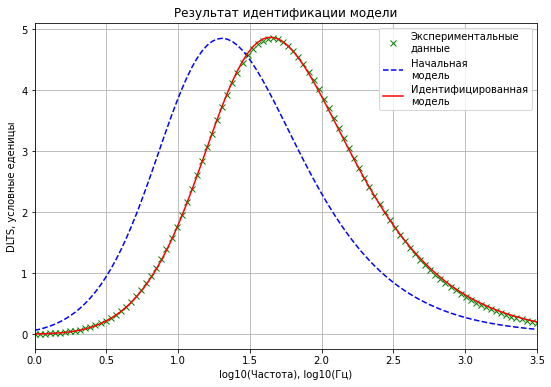

Спектр № 6
exps_params:
[[-2.2  1. ]
 [-2.1  1. ]
 [-2.   1. ]
 [-1.9  1. ]
 [-1.8  1. ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
6  4.816262           -1.999805  0.932132  0.000848


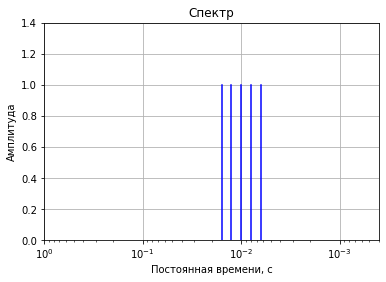

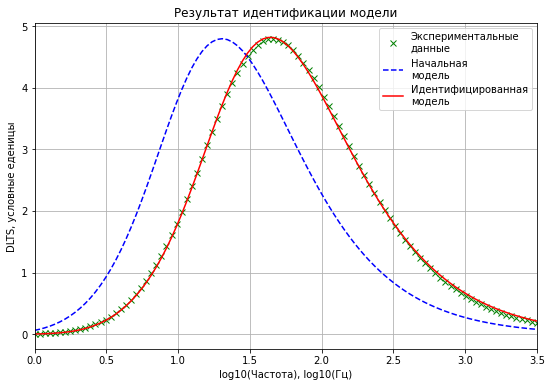

Спектр № 7
exps_params:
[[-2.23333333  1.        ]
 [-2.11666667  1.        ]
 [-2.          1.        ]
 [-1.88333333  1.        ]
 [-1.76666667  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
7  4.753943           -1.999598  0.909609  0.001503


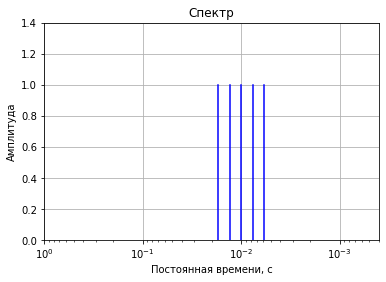

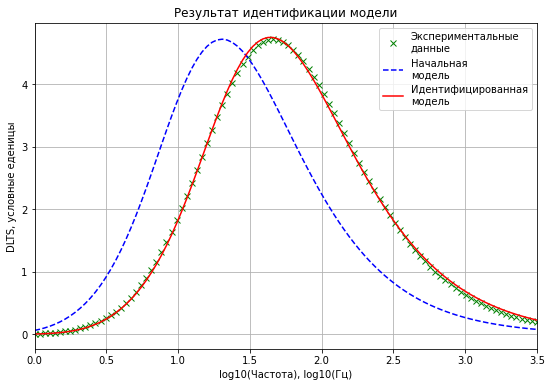

Спектр № 8
exps_params:
[[-2.26666667  1.        ]
 [-2.13333333  1.        ]
 [-2.          1.        ]
 [-1.86666667  1.        ]
 [-1.73333333  1.        ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
8  4.684436           -1.999274  0.884778  0.002439


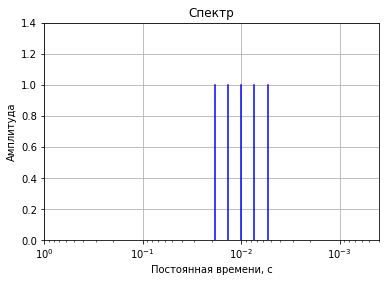

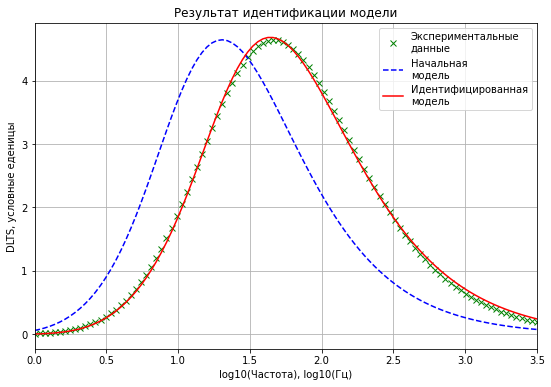

Спектр № 9
exps_params:
[[-2.3   1.  ]
 [-2.15  1.  ]
 [-2.    1.  ]
 [-1.85  1.  ]
 [-1.7   1.  ]]
Результаты идентификации:
  amplitude time_constant_power    p_coef      loss
9  4.608587           -1.998803  0.858024  0.003694


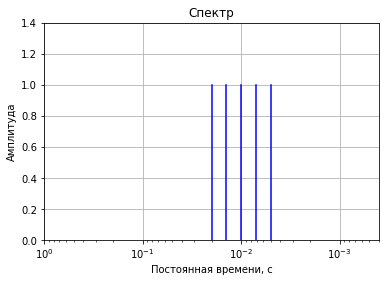

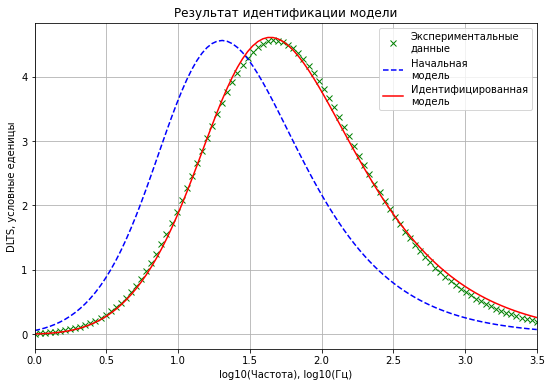

Спектр № 10
exps_params:
[[-2.33333333  1.        ]
 [-2.16666667  1.        ]
 [-2.          1.        ]
 [-1.83333333  1.        ]
 [-1.66666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
10  4.527261            -1.99815  0.829726  0.005295


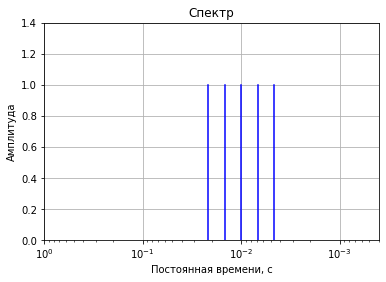

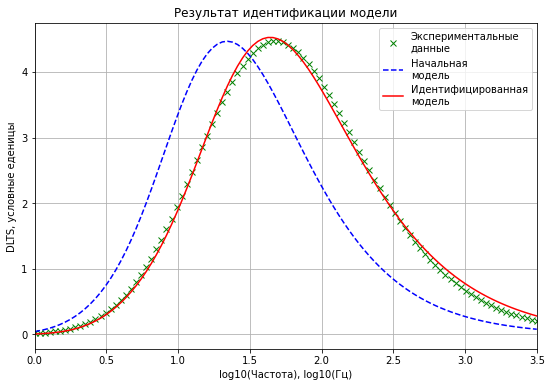

Спектр № 11
exps_params:
[[-2.36666667  1.        ]
 [-2.18333333  1.        ]
 [-2.          1.        ]
 [-1.81666667  1.        ]
 [-1.63333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
11  4.441306           -1.997284  0.800242  0.00725


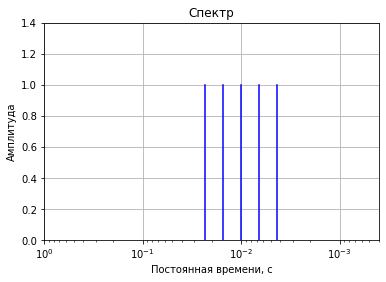

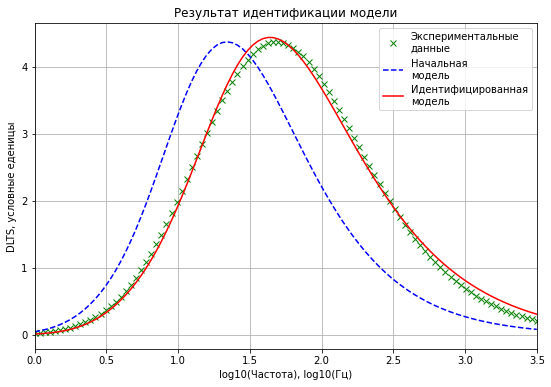

Спектр № 12
exps_params:
[[-2.4  1. ]
 [-2.2  1. ]
 [-2.   1. ]
 [-1.8  1. ]
 [-1.6  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
12   4.35155           -1.996171  0.769909  0.009553


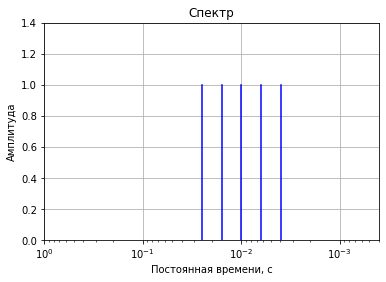

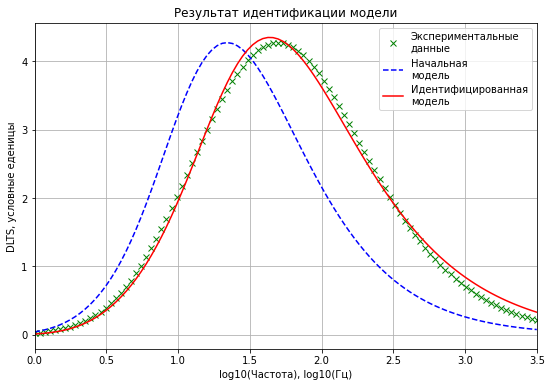

Спектр № 13
exps_params:
[[-2.43333333  1.        ]
 [-2.21666667  1.        ]
 [-2.          1.        ]
 [-1.78333333  1.        ]
 [-1.56666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
13  4.258781            -1.99478  0.739033  0.01218


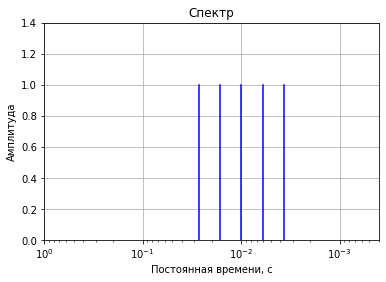

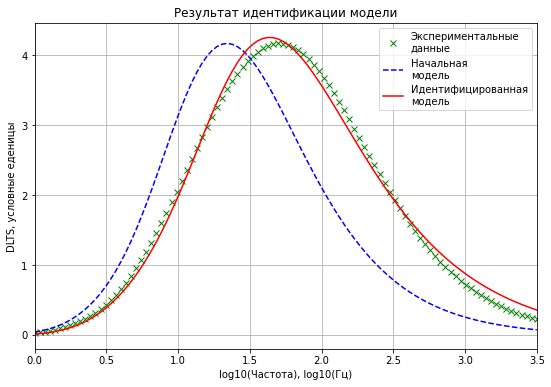

Спектр № 14
exps_params:
[[-2.46666667  1.        ]
 [-2.23333333  1.        ]
 [-2.          1.        ]
 [-1.76666667  1.        ]
 [-1.53333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
14  4.163737           -1.993084  0.707885  0.015091


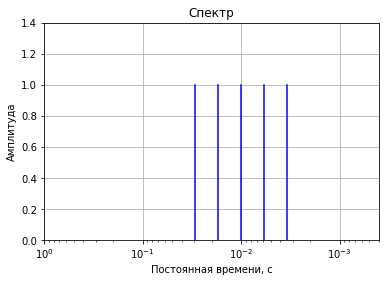

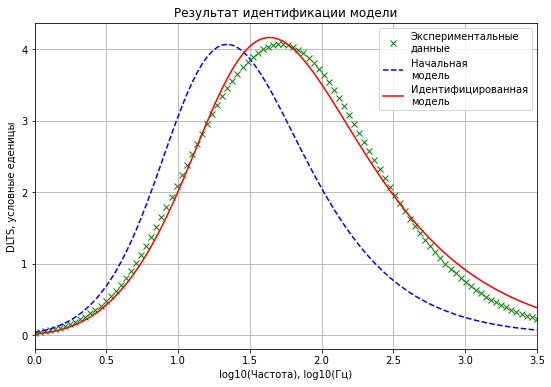

Спектр № 15
exps_params:
[[-2.5   1.  ]
 [-2.25  1.  ]
 [-2.    1.  ]
 [-1.75  1.  ]
 [-1.5   1.  ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
15  4.067097           -1.991056  0.676704  0.018231


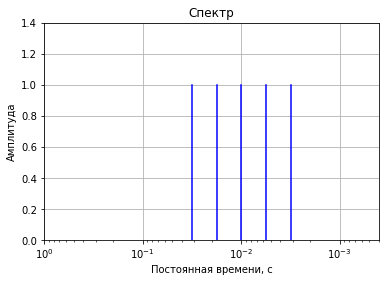

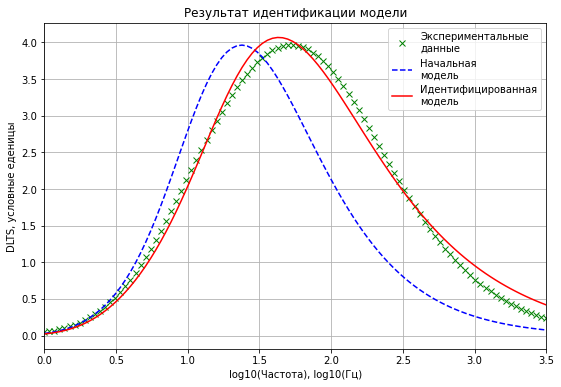

Спектр № 16
exps_params:
[[-2.53333333  1.        ]
 [-2.26666667  1.        ]
 [-2.          1.        ]
 [-1.73333333  1.        ]
 [-1.46666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
16   3.96948           -1.988677  0.645695  0.021535


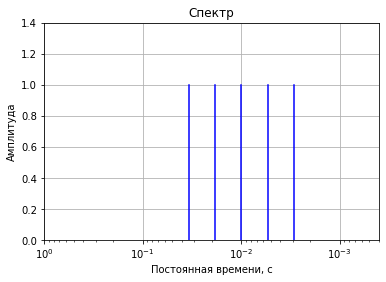

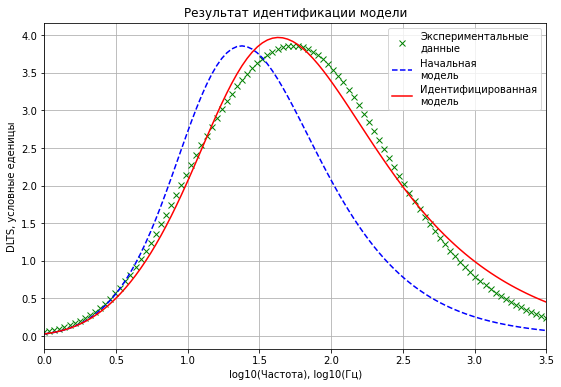

Спектр № 17
exps_params:
[[-2.56666667  1.        ]
 [-2.28333333  1.        ]
 [-2.          1.        ]
 [-1.71666667  1.        ]
 [-1.43333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
17  3.871452           -1.985931  0.615036  0.02493


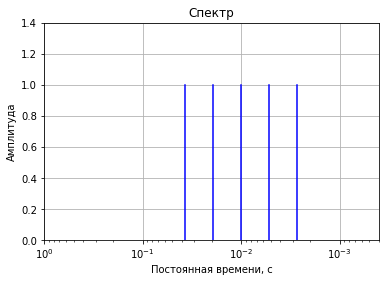

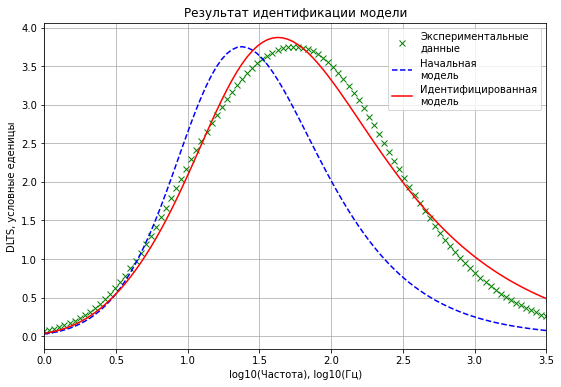

Спектр № 18
exps_params:
[[-2.6  1. ]
 [-2.3  1. ]
 [-2.   1. ]
 [-1.7  1. ]
 [-1.4  1. ]]
Результаты идентификации:
   amplitude time_constant_power   p_coef      loss
18  3.773505           -1.982811  0.58487  0.028336


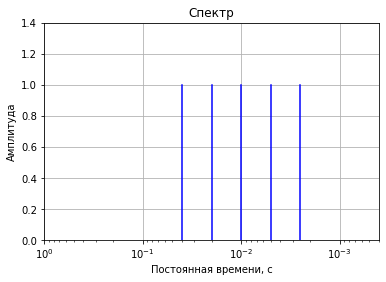

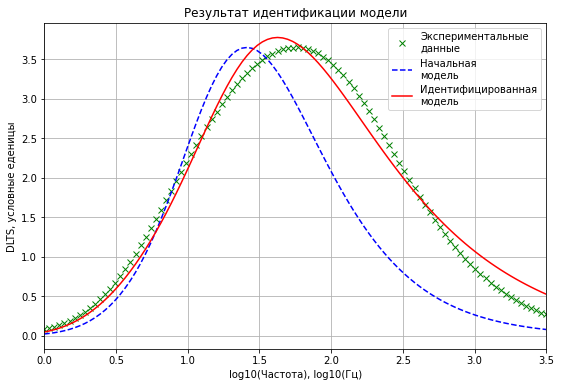

Спектр № 19
exps_params:
[[-2.63333333  1.        ]
 [-2.31666667  1.        ]
 [-2.          1.        ]
 [-1.68333333  1.        ]
 [-1.36666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
19  3.676083           -1.979316  0.555321  0.031672


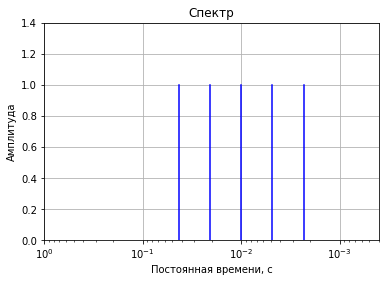

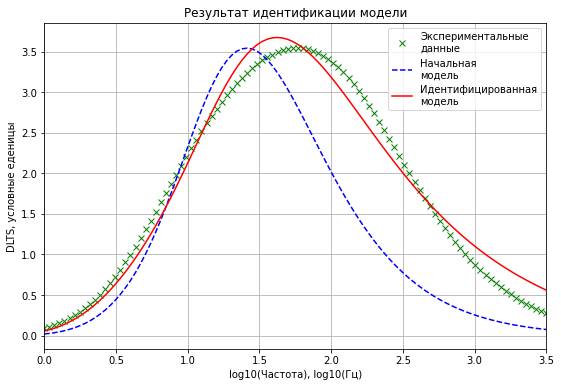

Спектр № 20
exps_params:
[[-2.66666667  1.        ]
 [-2.33333333  1.        ]
 [-2.          1.        ]
 [-1.66666667  1.        ]
 [-1.33333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
20  3.579572           -1.975453  0.526487  0.03486


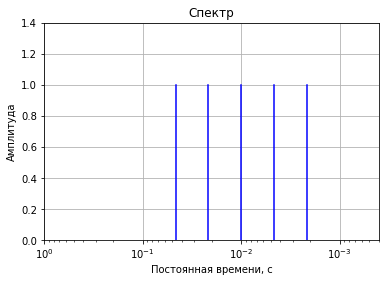

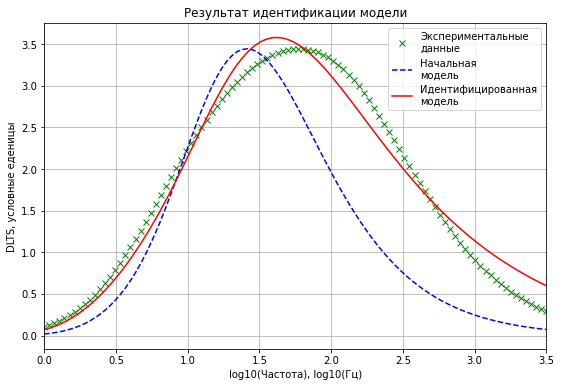

Спектр № 21
exps_params:
[[-2.7   1.  ]
 [-2.35  1.  ]
 [-2.    1.  ]
 [-1.65  1.  ]
 [-1.3   1.  ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
21  3.484303           -1.971239  0.498446  0.037825


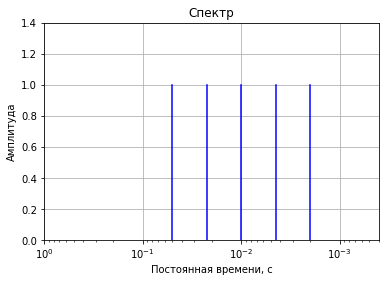

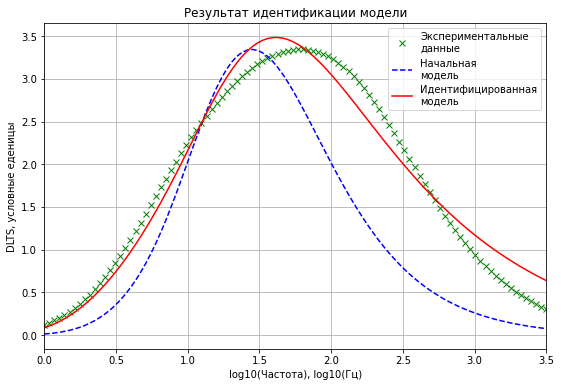

Спектр № 22
exps_params:
[[-2.73333333  1.        ]
 [-2.36666667  1.        ]
 [-2.          1.        ]
 [-1.63333333  1.        ]
 [-1.26666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
22  3.390558           -1.966697  0.471256  0.040501


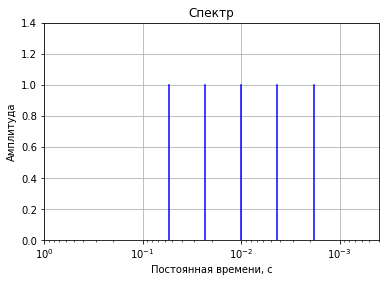

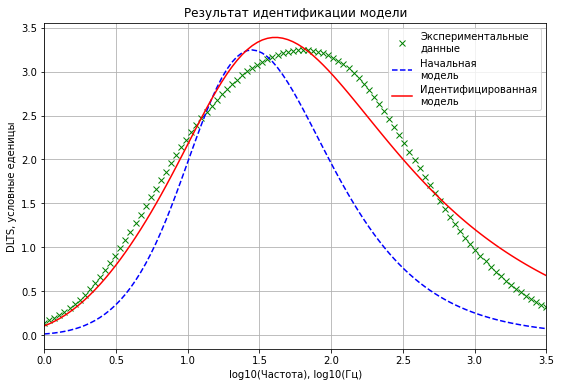

Спектр № 23
exps_params:
[[-2.76666667  1.        ]
 [-2.38333333  1.        ]
 [-2.          1.        ]
 [-1.61666667  1.        ]
 [-1.23333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
23  3.298747            -1.96186  0.444996  0.04283


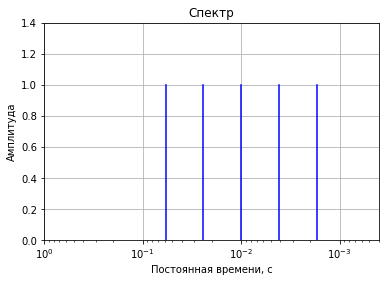

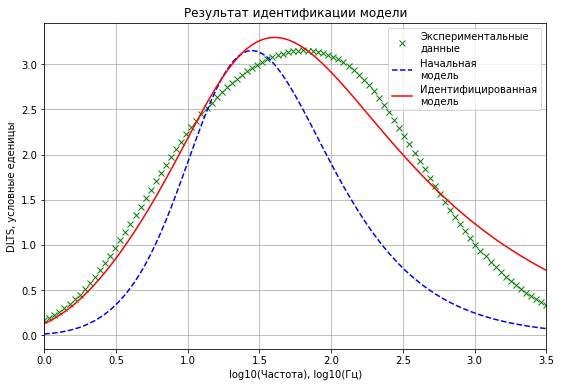

Спектр № 24
exps_params:
[[-2.8  1. ]
 [-2.4  1. ]
 [-2.   1. ]
 [-1.6  1. ]
 [-1.2  1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
24  3.208701           -1.956768  0.419621  0.044764


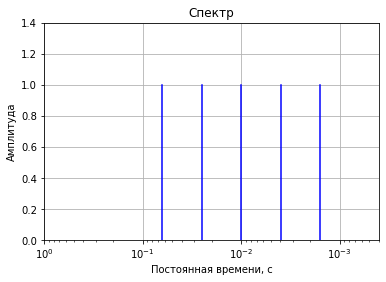

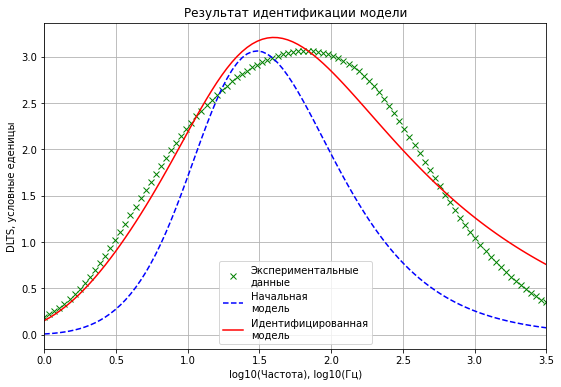

Спектр № 25
exps_params:
[[-2.83333333  1.        ]
 [-2.41666667  1.        ]
 [-2.          1.        ]
 [-1.58333333  1.        ]
 [-1.16666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef     loss
25   3.12075           -1.951465  0.395182  0.04627


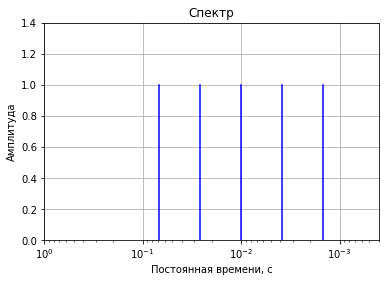

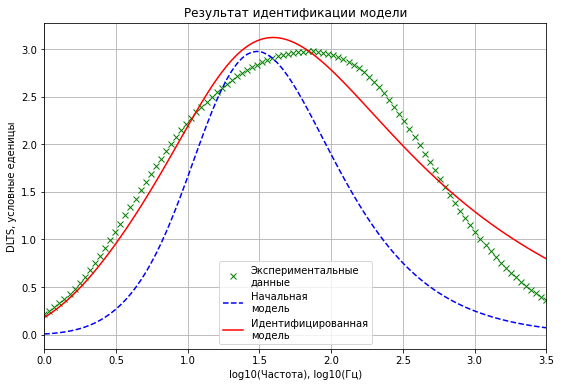

Спектр № 26
exps_params:
[[-2.86666667  1.        ]
 [-2.43333333  1.        ]
 [-2.          1.        ]
 [-1.56666667  1.        ]
 [-1.13333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
26  3.035002           -1.946003  0.371682  0.047325


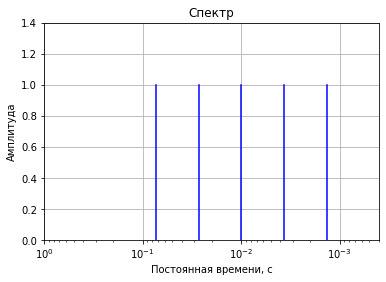

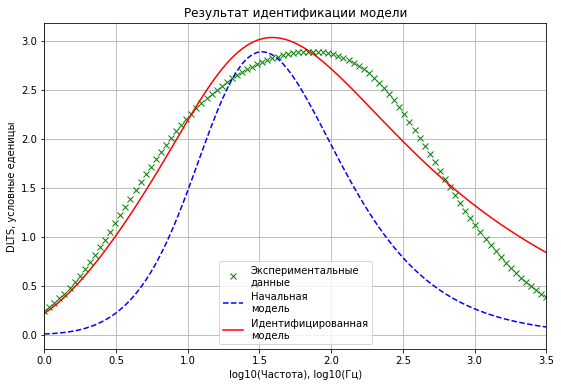

Спектр № 27
exps_params:
[[-2.9   1.  ]
 [-2.45  1.  ]
 [-2.    1.  ]
 [-1.55  1.  ]
 [-1.1   1.  ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
27  2.951531           -1.940435  0.349111  0.047916


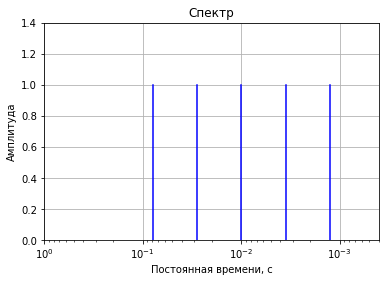

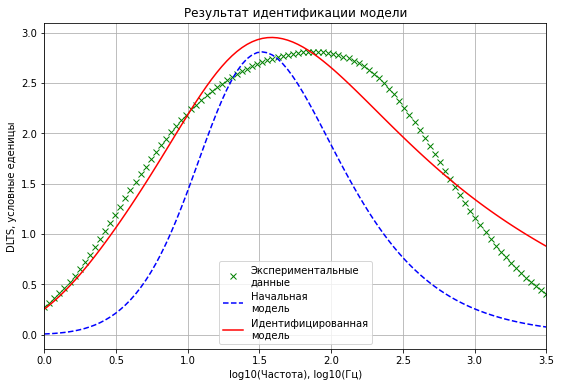

Спектр № 28
exps_params:
[[-2.93333333  1.        ]
 [-2.46666667  1.        ]
 [-2.          1.        ]
 [-1.53333333  1.        ]
 [-1.06666667  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
28  2.870378           -1.934817  0.327453  0.048044


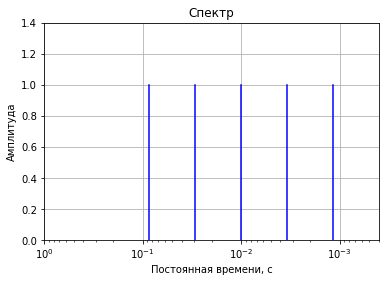

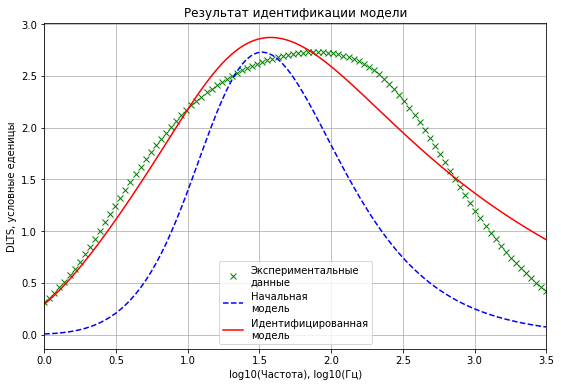

Спектр № 29
exps_params:
[[-2.96666667  1.        ]
 [-2.48333333  1.        ]
 [-2.          1.        ]
 [-1.51666667  1.        ]
 [-1.03333333  1.        ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
29  2.791566           -1.929206  0.306688  0.047717


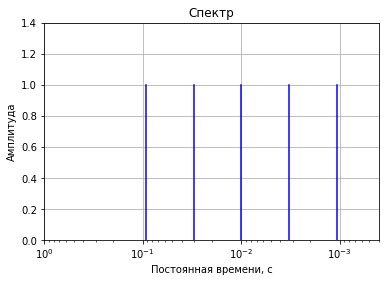

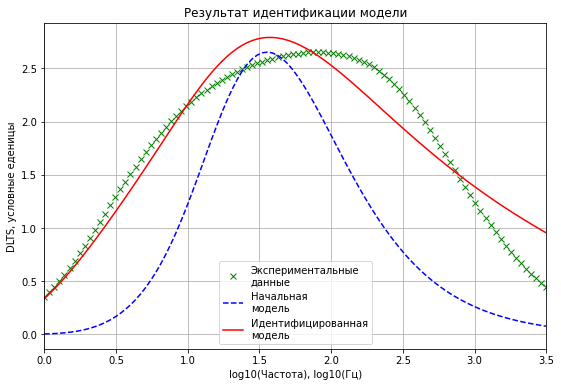

Спектр № 30
exps_params:
[[-3.   1. ]
 [-2.5  1. ]
 [-2.   1. ]
 [-1.5  1. ]
 [-1.   1. ]]
Результаты идентификации:
   amplitude time_constant_power    p_coef      loss
30  2.715088           -1.923662  0.286788  0.046957


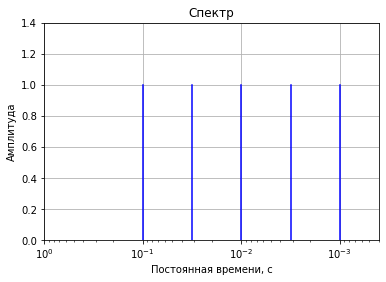

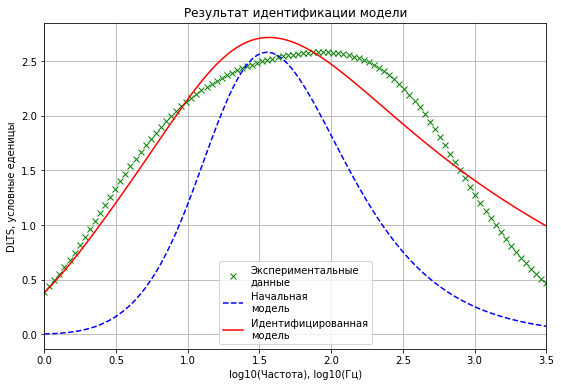

In [14]:
batch_plot(frequency_powers = FREQUENCY_POWERS, 
           experimental_values = test_data, 
           exps_params = exps_params,
           identification_results = identification_results,
           f_pulse = F_PULSE
          )

## Зависимость $p$ от расстояния между линиями на спектре

In [15]:
def plot_p(exps_params, final_params):
    plt.figure(figsize=(10,7))

    max_dev = 10 ** exps_params[:, -1, 0] - 10 ** exps_params[:, 0, 0]
    plt.plot(max_dev, final_params.p_coef.to_numpy())
    plt.title('Зависимость коэффициента $p$ от расстояния между линиями на спектре')
    plt.xlabel(r'$\tau_0 - \tau_2$')
    plt.ylabel('Коэффициент $p$')
    plt.grid()

    # plt.savefig('../plots/3-exp-clear/semilogx_p_func.pdf', bbox_inches='tight')

    plt.show()

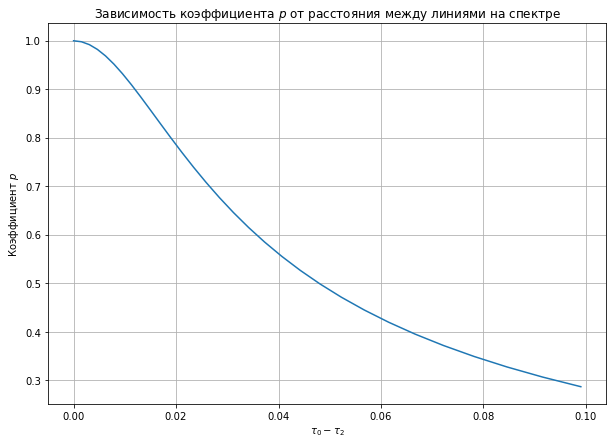

In [16]:
plot_p(exps_params=exps_params, final_params=identification_results['final_params'])